In [1]:
import numpy as np
import tensorflow as tf
import os, argparse
import cv2

print("numpy", np.__version__)
print("tensorflow", tf.__version__)
print("cv2", cv2.__version__)

os.chdir("COVID-Net/")
from data import process_image_file
import matplotlib.pyplot as plt
import sys

numpy 1.19.5
tensorflow 1.15.0
cv2 4.2.0


### Auxiliary functions to format images

In [2]:
#Convert a 2D image into a 3D image
def convert_2D_to_3D(img_2d):
    img_3d = np.copy(img_2d)
    img_3d = np.expand_dims(img_3d, axis=2)
    img_3d = np.tile(img_3d,[1,1,3])
    return img_3d

#Convert a BGR image into an RGB image
def convert_bgr_to_rgb(img):
    out_img = np.copy(img)
    out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    return out_img

#Function that will be used to convert a 2D saliency map (in the latent representation/dimension)
#into a 3D saliency map with the same dimension as the input (specified by "upsample_size").
#Optionally, a colormap can be applied to the 3D image for enhancing the visualization.
def upsize_map(cam_map, upsample_size, apply_colormap=False):
    cam_map_up = np.copy(cam_map)
    cam_map_up = cv2.resize(cam_map_up, upsample_size)
    cam_map_up = convert_2D_to_3D(cam_map_up)
    if apply_colormap:
        cam_map_up = np.uint8(255*cam_map_up)
        cam_map_up = cv2.applyColorMap(cam_map_up, cv2.COLORMAP_JET)
    return cam_map_up

In [3]:
# To remove TF Warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Model and task parameters

In [4]:
main_model = "COVIDNet-CXR-Small"

weightspath    = "pretrained/COVIDNet-CXR_Small"
metaname       = "model.meta"
ckptname       = "model-1697"
n_classes      = 3
in_tensorname  = "input_1:0"
out_tensorname = "dense_3/Softmax:0"
input_size     = 224
top_percent    = 0.08
is_severity_model    = False
last_conv_tensorname = "conv5_block3_out/add:0"
logits_tensorname    = "dense_3/BiasAdd:0"

### Prepare the classes of the problem

In [5]:
mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
mapping_keys = list(mapping.keys())

classes = np.array([c for c in mapping.keys()])
print("Classes:", classes)

Classes: ['normal' 'pneumonia' 'COVID-19']


### Load the model

In [6]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
tf.get_default_graph()
saver = tf.train.import_meta_graph(os.path.join(weightspath, metaname))
saver.restore(sess, os.path.join(weightspath, ckptname))

graph = tf.get_default_graph()

image_tensor      = graph.get_tensor_by_name(in_tensorname)
pred_tensor       = graph.get_tensor_by_name(out_tensorname)
logits_tensor     = graph.get_tensor_by_name(logits_tensorname)
last_conv_tensor  = graph.get_tensor_by_name(last_conv_tensorname)
print("Model loaded")

Model loaded


### Define all the tensors that will be used to generate the adversarial attacks 

In [7]:
with sess.graph.as_default():
    
    ## CROSS-ENTROPY LOSS DEFINITION
    target_class_onehot_ph = tf.placeholder("float", [1, n_classes])
    #Note that the tf function takes the logits to compute cross entropy:
    #> https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/losses/softmax_cross_entropy
    loss_ce_ev      = tf.losses.softmax_cross_entropy(target_class_onehot_ph, logits_tensor)
    grads_ce_tensor = tf.gradients(loss_ce_ev, image_tensor)
    
    ## COMPUTE CAM EXPLANATION USING TF AND THE GRAPH
    cam_one_hot_ph = tf.placeholder("float", [1, n_classes])  #Class of interest for the explanation
    cam_signal     = tf.multiply(pred_tensor, cam_one_hot_ph)
    cam_loss       = tf.reduce_mean(cam_signal)
    cam_grads      = tf.gradients(cam_loss, last_conv_tensor)[0]
    cam_weights    = tf.math.reduce_mean(cam_grads[0], axis=[0,1])
    cam_matmul     = last_conv_tensor @ cam_weights[..., tf.newaxis]
    cam_sq         = tf.squeeze(cam_matmul) 
    cam_relu       = tf.math.maximum(cam_sq, tf.zeros_like(cam_sq)) #Apply ReLU to remove negative values
    cam_tensor     = cam_relu/tf.math.reduce_max(cam_relu) #Final map (normalized between 0 and 1)
    
    ## EXPLANATION LOSS DEFINITION
    exp_target_map_ph = tf.placeholder("float", [7,7])
    exp_diff_loss     = tf.norm(exp_target_map_ph - cam_tensor, ord="euclidean")
    
    ## COMBINE CROSS-ENTROPY AND EXPLANATION LOSS
    tradeoff_ph  = tf.placeholder("float")
    loss_ce_exp  = loss_ce_ev*(1.0-tradeoff_ph) + exp_diff_loss*tradeoff_ph
    grads_ce_exp_tensor = tf.gradients(loss_ce_exp, image_tensor)

In [8]:
#Function to generate the Grad-CAM saliency map
def tf_generate_cam(x, exp_class, cam_tensor=cam_tensor, sess=sess, n_classes=n_classes):
    #Create a one-hot tensor, setting 1 for the class to be explained ("exp_class")
    exp_class_onehot = np.zeros(n_classes)
    exp_class_onehot[exp_class] = 1.0
    #Compute the saliency-map
    tf_cam = sess.run(cam_tensor,
                      {image_tensor:   np.expand_dims(x, axis=0), 
                       cam_one_hot_ph: np.expand_dims(exp_class_onehot, axis=0)})
    return tf_cam

### Parameters of the adversarial attack (that will be used below in the attacks)

In [9]:
eps_val = 0.015       #Maximum distortion threshold
step_size_val = 0.001 #Step size at each iteration in the PGD attack

### Load the image

In [10]:
imagepath  = "data/test/MIDRC-RICORD-1C-SITE2-000003-00527-0.png"
origin_im  = cv2.imread(imagepath)
size_upsample = (origin_im.shape[1],origin_im.shape[0]) #Input dimensions (w, h)

x_load = process_image_file(imagepath, top_percent, input_size)
x      = np.copy(x_load).astype('float32') / 255.0

#Clean prediction
pred   = sess.run(pred_tensor, feed_dict={image_tensor: np.expand_dims(x, axis=0)})

source_class = np.argmax(pred[0])
print('Prediction: {}'.format(inv_mapping[source_class]))
print('Confidence')
print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
print('**DISCLAIMER**')
print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

Prediction: COVID-19
Confidence
Normal: 0.000 Pneumonia: 0.000 Covid-19: 1.000
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


### Plot the original image

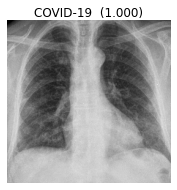

In [11]:
plt.imshow(x_load)
plt.gcf().set_size_inches((3,3))
plt.axis("off")
plot_title = "%s  (%.3f)"%(classes[source_class],np.max(pred))
plt.title(plot_title,y=0.98)
plt.savefig("/tmp/original_xray.pdf", dpi=300, bbox_inches="tight")
plt.show()

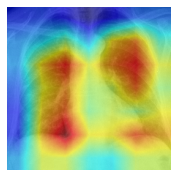

In [12]:
tf_cam = tf_generate_cam(x, source_class, cam_tensor, sess)

#Upsize the map to fit the original input size
tf_cam3_nomap  = upsize_map(tf_cam, (input_size,input_size), apply_colormap=False)
#Apply colormap
tf_cam3 = np.uint8(255*tf_cam3_nomap)
tf_cam3 = cv2.applyColorMap(tf_cam3, cv2.COLORMAP_JET)

#Plot the saliency-map overl the original image
plt.imshow(x)
plt.imshow(convert_bgr_to_rgb(tf_cam3), alpha=0.6)
plt.axis("off")
plt.gcf().set_size_inches((3,3))
plt.savefig("/tmp/original_xray_exp.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Regular Attack: Change the output class

In [13]:
target_class = 0 #normal

target_class_onehot = np.zeros(n_classes)
target_class_onehot[target_class] = 1.0
print("Target class (one-hot):", target_class_onehot)

Target class (one-hot): [1. 0. 0.]


In [14]:
pred_logits, pred_softmax = sess.run([logits_tensor,pred_tensor], 
                                     feed_dict={image_tensor: np.expand_dims(x, axis=0)})
class_idxs_sorted = np.argsort(pred_softmax.flatten())[::-1]
print("Prediction (ordered):", str(class_idxs_sorted))
print("Softmax:", str(pred_softmax[0,:]))
print("Logits :", str(pred_logits[0, :]))

Prediction (ordered): [2 0 1]
Softmax: [7.2070014e-07 3.3051487e-07 9.9999893e-01]
Logits : [-4.900236  -5.679808   9.2428055]


In [15]:
eps       = eps_val       #maximum amomunt of distortion allowed
step_size = step_size_val #step size of the attack
n_iters   = 20            #number of iterations

src_img_copy = np.copy(x) #copy of the clean image
cur_adv      = np.copy(x) #initialize the adversarial example with the clean image

for i in range(n_iters):
    #Compute gradients
    tmp_check_loss, cur_grads_opt = sess.run([loss_ce_ev, grads_ce_tensor],
                             {image_tensor:           np.expand_dims(cur_adv, axis=0), 
                              target_class_onehot_ph: np.expand_dims(target_class_onehot, axis=0)})
    cur_grads_opt = np.copy(cur_grads_opt[0][0]) #remove extra dimensions
    print("Loss: %.8f"%tmp_check_loss)
    
    #Perturb the input
    cur_adv = cur_adv - np.sign(cur_grads_opt)*step_size
    #Constraints:
    cur_adv = np.clip(cur_adv, src_img_copy-eps, src_img_copy+eps) #perturbation norm
    cur_adv = np.clip(cur_adv, 0.0, 1.0) #valid image range
    #Keep the 3 channels equal (only first channel modified)
    cur_adv[:,:,1] = np.copy(cur_adv[:,:,0])
    cur_adv[:,:,2] = np.copy(cur_adv[:,:,0])
    
    #Check the prediction of the perturbed input:
    cur_logits, cur_softmax = sess.run([logits_tensor,pred_tensor], 
                                       feed_dict={image_tensor: np.expand_dims(cur_adv, axis=0)})
    print("Predicted class: %d (target: %d)"%(np.argmax(cur_softmax),target_class), np.round(cur_softmax[0,:],6))

Loss: 14.14304256
Predicted class: 2 (target: 0) [1.90000e-05 8.00000e-06 9.99973e-01]
Loss: 10.88239098
Predicted class: 2 (target: 0) [3.17000e-04 1.25000e-04 9.99558e-01]
Loss: 8.05814457
Predicted class: 2 (target: 0) [0.004592 0.002128 0.99328 ]
Loss: 5.38335276
Predicted class: 2 (target: 0) [0.062337 0.030212 0.907451]
Loss: 2.77519846
Predicted class: 0 (target: 0) [0.524451 0.21156  0.263988]
Loss: 0.64540273
Predicted class: 0 (target: 0) [0.754102 0.236466 0.009432]
Loss: 0.28222817
Predicted class: 0 (target: 0) [0.890158 0.071242 0.0386  ]
Loss: 0.11635660
Predicted class: 0 (target: 0) [0.939049 0.059547 0.001404]
Loss: 0.06288754
Predicted class: 0 (target: 0) [0.969552 0.021305 0.009143]
Loss: 0.03092100
Predicted class: 0 (target: 0) [9.84015e-01 1.56760e-02 3.09000e-04]
Loss: 0.01611400
Predicted class: 0 (target: 0) [0.992257 0.006697 0.001046]
Loss: 0.00777315
Predicted class: 0 (target: 0) [9.95886e-01 4.03900e-03 7.50000e-05]
Loss: 0.00412221
Predicted class: 0 (t

In [16]:
#Round/rescale the adversarial example to be sure that it meets the image format criteria
cur_adv = np.clip(np.array(cur_adv*255, dtype=np.uint8), 0, 255)
cur_adv = np.copy(cur_adv).astype("float")/255.0

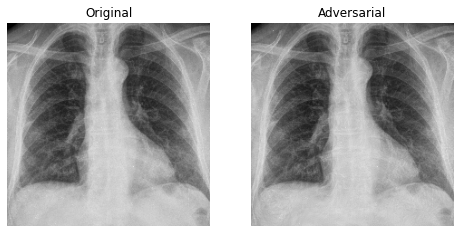

In [17]:
fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].imshow(x) ; axes[0].set_title("Original") ; axes[0].axis("off") 
axes[1].imshow(cur_adv) ; axes[1].set_title("Adversarial") ; axes[1].axis("off") 
plt.show()

In [18]:
#Clean prediction
pred_logits, pred_softmax = sess.run([logits_tensor,pred_tensor], 
                                     feed_dict={image_tensor: np.expand_dims(x, axis=0)})
class_idxs_sorted = np.argsort(pred_softmax.flatten())[::-1]

#Adversarial prediction
adv_logits, adv_softmax = sess.run([logits_tensor,pred_tensor], 
                                     feed_dict={image_tensor: np.expand_dims(cur_adv, axis=0)})
adv_idxs_sorted = np.argsort(adv_softmax.flatten())[::-1]

print("Pred. ordered:", str(class_idxs_sorted), "-->", str(adv_idxs_sorted))
print("Softmax      :", np.round(pred_softmax[0,:],3), "-->", np.round(adv_softmax[0,:],3))
print("Logits       :", np.round(pred_logits[0,:], 3), "-->", np.round(adv_logits[0,:], 3))

Pred. ordered: [2 0 1] --> [0 1 2]
Softmax      : [0. 0. 1.] --> [1. 0. 0.]
Logits       : [-4.9   -5.68   9.243] --> [ 9.053 -0.82  -6.257]


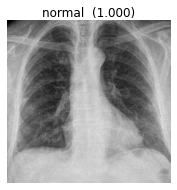

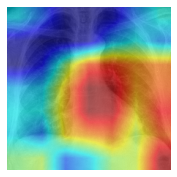

In [19]:
#Plot the adversarial example
plt.imshow(cur_adv)
plt.axis("off")
plot_title = "%s  (%.3f)"%(classes[np.argmax(adv_softmax)],np.max(adv_softmax))
plt.title(plot_title,y=0.98)
plt.gcf().set_size_inches((3,3))
plt.savefig("/tmp/adv_reg_xray.pdf", dpi=300, bbox_inches="tight")
plt.show()

#Plot the Grad-CAM saliency map (over the adversarial image)
assert target_class==np.argmax(adv_softmax)
cur_cam    = tf_generate_cam(cur_adv, target_class, cam_tensor, sess)
cur_cam_up = upsize_map(cur_cam, (input_size,input_size), apply_colormap=True)
plt.imshow(cur_adv)
plt.imshow(convert_bgr_to_rgb(cur_cam_up), alpha=0.6) #Opencv loads in BGR format by default (we want RGB)
plt.axis("off")
plt.gcf().set_size_inches((3,3))
plt.savefig("/tmp/adv_reg_xray_exp.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Generalized Attack: Controlling the output and the explanation

In [20]:
#Clean prediction
pred         = sess.run(pred_tensor, feed_dict={image_tensor: np.expand_dims(x, axis=0)})
source_class = np.argmax(pred)

In [21]:
#Original saliency map
source_map = tf_generate_cam(x, source_class, cam_tensor, sess)

Target explanation mode: samexp
Target class (one-hot): [1. 0. 0.]


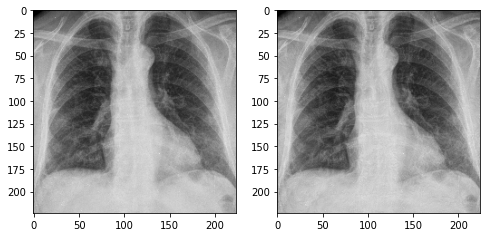

Pred. ordered: [2 0 1] --> [0 1 2]
Softmax      : [0. 0. 1.] --> [0.984 0.016 0.   ]
Logits       : [-4.9   -5.68   9.243] --> [ 5.61   1.519 -5.25 ]


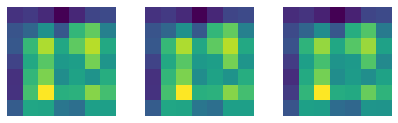

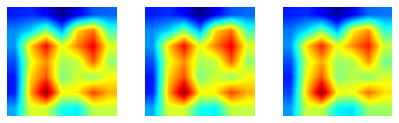

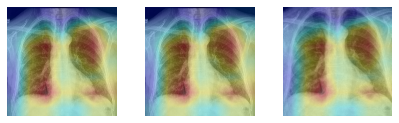

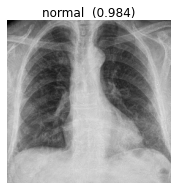

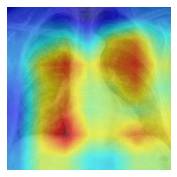






Target explanation mode: half
Target class (one-hot): [0. 0. 1.]


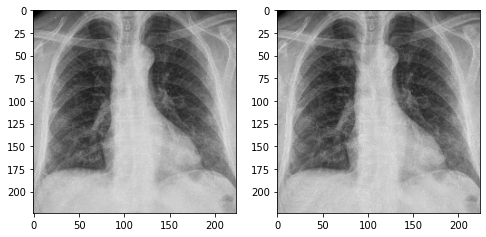

Pred. ordered: [2 0 1] --> [2 0 1]
Softmax      : [0. 0. 1.] --> [0. 0. 1.]
Logits       : [-4.9   -5.68   9.243] --> [-2.49  -5.147  6.205]


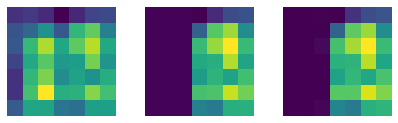

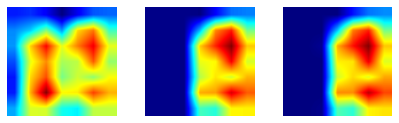

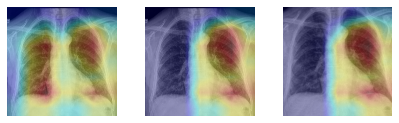

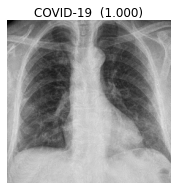

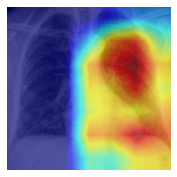






Target explanation mode: both
Target class (one-hot): [1. 0. 0.]


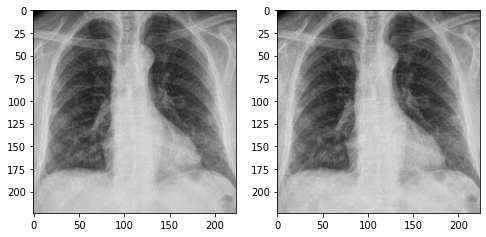

Pred. ordered: [2 0 1] --> [0 1 2]
Softmax      : [0. 0. 1.] --> [0.941 0.059 0.   ]
Logits       : [-4.9   -5.68   9.243] --> [ 4.946  2.171 -5.079]


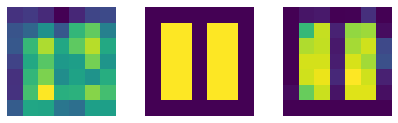

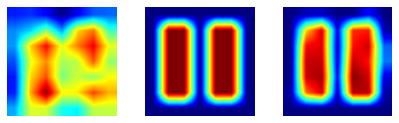

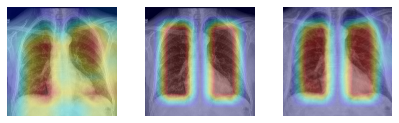

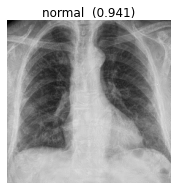

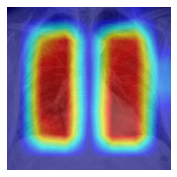






Target explanation mode: out
Target class (one-hot): [1. 0. 0.]


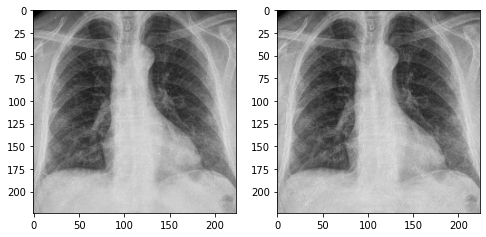

Pred. ordered: [2 0 1] --> [0 2 1]
Softmax      : [0. 0. 1.] --> [0.958 0.01  0.031]
Logits       : [-4.9   -5.68   9.243] --> [ 2.767 -1.756 -0.65 ]


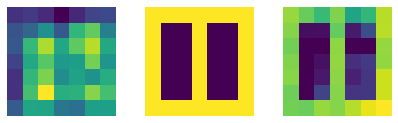

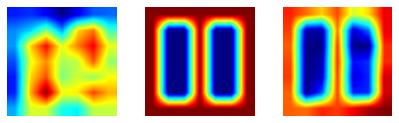

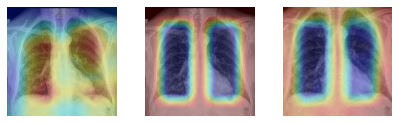

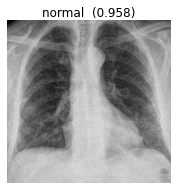

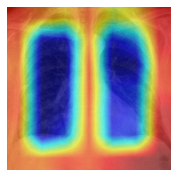

In [22]:
#We will target 4 different explanations:
#1) the original saliency map (i.e., the one obtained for the clean image)
#2) the right half of the original saliency map (i.e., setting to zero the values of the original map)
#3) a roughly uniform map over    the two main parts of the image only 
#4) a roughly uniform map outside the two main parts of the image only
for exp_type in ["samexp", "half", "both", "out"]:
    
    print("Target explanation mode: %s"%exp_type )
    
    if exp_type=="samexp":
        target_class = 0 #normal
        target_map   = np.copy(source_map)
    if exp_type=="half":
        target_class = 2 #COVID-19
        target_map   = np.copy(source_map)
        target_map[:,0:(target_map.shape[1]//2)] = 0.01 #remove the left half of the original explanation
        target_map   = target_map/np.max(target_map)    #Target map is in [0,1]
    if exp_type=="both":
        target_class = 0 #normal
        target_map   = np.zeros(source_map.shape)
        for i in range(1,6):
            for j in range(1,3): 
                target_map[i,j]=1.0
        for i in range(1,6):
            for j in range(4,6):
                target_map[i,j]=1.0
    if exp_type=="out":
        target_class = 0 #normal
        target_map   = np.zeros(source_map.shape)
        for i in range(1,6):
            for j in range(1,3): 
                target_map[i,j]=1.0
        for i in range(1,6):
            for j in range(4,6):
                target_map[i,j]=1.0
        target_map = np.abs(target_map-1.0)

    #Sanity check
    assert np.all(target_map)>=0.0 and np.all(target_map)<=(1.0)
    
    #Create the one-hot vector representation of the target class
    target_class_onehot = np.zeros(n_classes)
    target_class_onehot[target_class] = 1.0
    print("Target class (one-hot):", target_class_onehot)

    
    #Attack parameters
    eps       = eps_val       #maximum distortion allowed
    step_size = step_size_val #step size of the adversarial attack
    n_iters   = 200           #number of iterations
    tradeoff_param = 0.5 #trade-off parameter between minimizing the prediction loss and the explanation loss

    
    src_img_copy = np.copy(x) #backup copy of the original input 
    cur_adv = np.copy(x)      #initialize the adversarial example
    heatmap = np.zeros(target_map.shape) #empty heatmap

    #To select the optimum adversarial example
    opt_loss = np.inf
    opt_adv  = np.copy(cur_adv)

    for i in range(n_iters):
        #Check if the model alredy predicts the target class
        cur_pred = sess.run(pred_tensor, feed_dict={image_tensor: np.expand_dims(cur_adv, axis=0)})
        if np.argmax(cur_pred)!=target_class:
            #Optimize the prediction loss
            tmp_check_loss_ce, cur_grads_opt = sess.run([loss_ce_ev,grads_ce_tensor],
                                 {image_tensor:           np.expand_dims(cur_adv, axis=0), 
                                  target_class_onehot_ph: np.expand_dims(target_class_onehot, axis=0)})

        else:
            #Optimize the perturbation to change both the output class and the explanation jointly
            heatmap,\
            tmp_check_loss_ce,\
            tmp_check_loss_exp,\
            tmp_check_loss_ce_exp,\
            cur_grads_opt = sess.run([cam_tensor, loss_ce_ev, exp_diff_loss, loss_ce_exp, grads_ce_exp_tensor],
                                     {image_tensor:           np.expand_dims(cur_adv, axis=0), 
                                      target_class_onehot_ph: np.expand_dims(target_class_onehot, axis=0),
                                      cam_one_hot_ph:         np.expand_dims(target_class_onehot, axis=0),
                                      exp_target_map_ph:      target_map,
                                      tradeoff_ph:            tradeoff_param})

        cur_grads_opt = np.copy(cur_grads_opt[0][0]) #Remove extra dimensions

        #Perturb the input
        cur_adv = cur_adv - np.sign(cur_grads_opt)*step_size
        #Constraints:
        cur_adv = np.clip(cur_adv, src_img_copy-eps, src_img_copy+eps) #Perturbation norm
        cur_adv = np.clip(cur_adv, 0.0, 1.0) #valid image range
        #Keep the 3 channels equal (only first channel modified)
        cur_adv[:,:,1] = np.copy(cur_adv[:,:,0])
        cur_adv[:,:,2] = np.copy(cur_adv[:,:,0])

        #Prediction of the current adversarial example
        cur_pred = sess.run(pred_tensor, feed_dict={image_tensor: np.expand_dims(cur_adv, axis=0)})
        if np.argmax(cur_pred)==target_class:
            tmp_check_loss_ce,\
            tmp_check_loss_exp,\
            tmp_check_loss_ce_exp = sess.run([loss_ce_ev, exp_diff_loss, loss_ce_exp],
                                             {image_tensor:           np.expand_dims(cur_adv, axis=0), 
                                              target_class_onehot_ph: np.expand_dims(target_class_onehot, axis=0),
                                              cam_one_hot_ph:         np.expand_dims(target_class_onehot, axis=0),
                                              exp_target_map_ph:      target_map,
                                              tradeoff_ph:            tradeoff_param})

            if opt_loss > tmp_check_loss_ce_exp:
                opt_loss = np.copy(tmp_check_loss_ce_exp)
                opt_adv  = np.copy(cur_adv)

    #Final adversarial example
    cur_adv = np.copy(opt_adv)
    #Round/rescale the adversarial example to be sure that meets the image format criteria
    cur_adv = np.clip(np.array(np.round(cur_adv*255),dtype=np.uint8),0,255)
    cur_adv = np.copy(cur_adv).astype("float")/255.0
    #To compare the clean input and the adversarial input
    fig, axes = plt.subplots(1,2,figsize=(8,8))
    axes[0].imshow(x) 
    axes[1].imshow(cur_adv)
    plt.show()

    #Clean prediction
    pred_logits, pred_softmax = sess.run([logits_tensor,pred_tensor], 
                                         feed_dict={image_tensor: np.expand_dims(x, axis=0)})
    class_idxs_sorted = np.argsort(pred_softmax.flatten())[::-1]
    
    #Adversarial prediction
    adv_logits, adv_softmax   = sess.run([logits_tensor,pred_tensor], 
                                         feed_dict={image_tensor: np.expand_dims(cur_adv, axis=0)})
    adv_idxs_sorted = np.argsort(adv_softmax.flatten())[::-1]

    print("Pred. ordered:", str(class_idxs_sorted), "-->", str(adv_idxs_sorted))
    print("Softmax      :", np.round(pred_softmax[0,:],3), "-->", np.round(adv_softmax[0,:],3))
    print("Logits       :", np.round(pred_logits[0,:], 3), "-->", np.round(adv_logits[0,:], 3))


    #Compare the source map, the target map and the achieved adversarial map
    adv_cam   = tf_generate_cam(cur_adv, target_class, cam_tensor, sess)
    #
    fig, axes = plt.subplots(1,3,figsize=(7,2))
    axes[0].imshow(source_map)
    axes[1].imshow(target_map)
    axes[2].imshow(adv_cam)
    axes[0].axis("off"); axes[1].axis("off"); axes[2].axis("off")
    plt.show()

    #Compare the same 3 maps as before but upsampled
    source_map_up = upsize_map(source_map, size_upsample,           apply_colormap=True)
    target_map_up = upsize_map(target_map, size_upsample,           apply_colormap=True)
    adv_cam_up    = upsize_map(adv_cam,    (input_size,input_size), apply_colormap=True)
    fig, axes = plt.subplots(1,3,figsize=(7,2))
    axes[0].imshow(convert_bgr_to_rgb(source_map_up))
    axes[1].imshow(convert_bgr_to_rgb(target_map_up))
    axes[2].imshow(convert_bgr_to_rgb(adv_cam_up))   
    axes[0].axis("off"); axes[1].axis("off"); axes[2].axis("off")
    plt.show()

    #Compare the 3 maps overlayed on the corresponding (clean or adversarial) image
    fig, axes = plt.subplots(1,3,figsize=(7,2))
    axes[0].imshow(origin_im) 
    axes[0].imshow(convert_bgr_to_rgb(source_map_up), alpha=0.3) 
    axes[1].imshow(origin_im) 
    axes[1].imshow(convert_bgr_to_rgb(target_map_up), alpha=0.3) 
    axes[2].imshow(cur_adv)
    axes[2].imshow(convert_bgr_to_rgb(adv_cam_up),    alpha=0.3)    
    axes[0].axis("off"); axes[1].axis("off"); axes[2].axis("off")
    plt.show()

    
    #Adversarial example
    plt.imshow(cur_adv)
    plt.axis("off")
    plot_title = "%s  (%.3f)"%(classes[np.argmax(adv_softmax)],np.max(adv_softmax))
    plt.title(plot_title,y=0.98)
    plt.gcf().set_size_inches((3,3))
    plt.savefig("/tmp/adv_%s_xray.pdf"%exp_type, dpi=300, bbox_inches="tight")
    plt.show()

    #Explanation map over the image
    assert target_class==np.argmax(adv_softmax)
    cur_cam    = tf_generate_cam(cur_adv, target_class, cam_tensor, sess)
    cur_cam_up = upsize_map(cur_cam, (input_size,input_size), apply_colormap=True)
    plt.imshow(cur_adv)
    plt.imshow(convert_bgr_to_rgb(cur_cam_up), alpha=0.6) #Opencv loads in BGR format by default (we want RGB)
    plt.axis("off")
    plt.gcf().set_size_inches((3,3))
    plt.savefig("/tmp/adv_%s_xray_exp.pdf"%exp_type, dpi=300, bbox_inches="tight")
    plt.show()

    print("\n\n\n\n")